In [32]:
import cv2
import numpy as np

import torch
from torchvision import models

import openvino as ov

from PIL import Image
from IPython.display import display

In [2]:
pt_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, progress=True)

In [3]:
ov_model = ov.convert_model(pt_model)
ov.save_model(ov_model, 'resnet50.xml')

In [5]:
ov_model.reshape((1,3,224,224))
compiled_model = ov.compile_model(ov_model, device_name='CPU')
compiled_model

<CompiledModel:
inputs[
<ConstOutput: names[x] shape[1,3,224,224] type: f32>
]
outputs[
<ConstOutput: names[x.45] shape[1,1000] type: f32>
]>

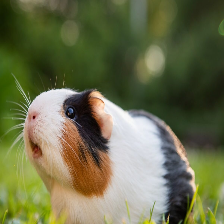

(1, 3, 224, 224)

In [20]:
img = cv2.imread('guineapig.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
display(Image.fromarray(img))
img = img.astype(np.float32) / 255.0 - 0.5
img = np.transpose(img, (2,0,1))
img = np.expand_dims(img, axis=0)
img.shape

In [30]:
result = compiled_model.infer_new_request(img)
result = result[0].ravel()
print(result.shape, result[:40])

(1000,) [ 3.49133871e-02 -3.73559073e-02 -3.29932958e-01 -1.34431154e-01
 -1.68923214e-01 -2.04616830e-01 -1.76480308e-01  5.38860261e-03
  1.67652026e-01 -5.16679846e-02  4.14942414e-01  2.27172062e-01
 -1.49384692e-01  6.63757980e-01 -3.94901447e-02 -2.42644493e-02
  2.15369202e-02  2.27100449e-04  5.41826375e-02  1.88348144e-01
  2.10968286e-01  2.91639447e-01 -2.26552874e-01 -1.42830595e-01
  1.21185824e-01  6.09142371e-02 -2.25566281e-03  2.37515852e-01
  6.14832528e-02  7.90906027e-02 -5.53958453e-02  1.52902037e-01
 -1.14440888e-01 -2.69625217e-01 -9.49208513e-02 -5.14691100e-02
 -1.72885433e-01 -1.74013302e-02 -2.22887382e-01 -9.86031517e-02]


In [28]:
indices = np.argsort(result)[::-1]

for index in indices[:5]:
    print(index, result[index])

338 6.5218515
336 1.123393
337 0.9869988
333 0.7737263
232 0.7318341


In [26]:
with open('synset_words.txt') as f:
    imagenet_labels = [ line.rstrip().split(maxsplit=1)[1] for line in f.readlines() ]

for index in indices[:5]:
    print(index, imagenet_labels[index], result[index])

338 guinea pig, Cavia cobaya 6.5218515
336 marmot 1.123393
337 beaver 0.9869988
333 hamster 0.7737263
232 Border collie 0.7318341


In [40]:
import time

niter = 100

dummy_data = np.zeros((1,3,224,224), dtype=np.float32)

stime = time.time()
dummy_tensor = torch.Tensor(dummy_data)
for _ in range(niter):
    pt_model(dummy_tensor)
etime = time.time()
print(f'PyTorch  : {etime-stime:6.3f} sec')

stime = time.time()
dummy_tensor = torch.Tensor(dummy_data)
for _ in range(niter):
    compiled_model(dummy_data)
etime = time.time()
print(f'OpenVINO : {etime-stime:6.3f} sec')

PyTorch  :  4.455 sec
OpenVINO :  1.498 sec
